# 🏡 Housing Price Prediction — Data Exploration & Preprocessing Notebook

### Overview
This notebook performs **exploratory data analysis (EDA)** and **preprocessing** on the Ames Housing dataset from Kaggle:  
🔗 https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

It includes:

- **Initial dataset loading and inspection**
- **Target variable exploration**  
  - Original SalePrice distribution  
  - Log-transformed distribution  
- **Missing value analysis** with visualizations
- **Feature engineering** (TotalSF, HouseAge, RemodelAge)
- **Outlier detection & removal** using IQR
- **Correlation analysis**
  - Full numeric correlation heatmap  
  - Top 20 features most correlated with SalePrice  
- **Preparation of a cleaned, feature-enhanced dataset** for downstream modeling

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
sns.set(style="whitegrid")


In [7]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



## Original Target Distribution (SalePrice)
- The histogram shows that **SalePrice is heavily right-skewed**.
- Most homes are priced between **$100k–$200k**, with fewer high-priced homes.
- This skewness can negatively affect linear models.

**Why it matters:**  
Skewed distributions cause models to perform poorly on high-value homes. Transformation or outlier handling is needed.

---

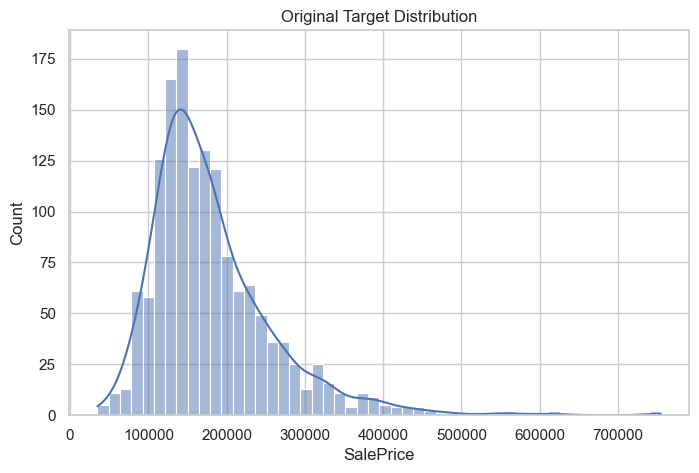

In [8]:
target = 'SalePrice'

plt.figure(figsize=(8,5))
sns.histplot(train_df[target], kde=True, bins=50)
plt.title('Original Target Distribution')
plt.show()

## Log-Transformed Target Distribution
- Applying `log1p()` creates a **more symmetric, bell-shaped distribution**.
- Helps models learn patterns more effectively.
- Reduces the influence of extremely high sale prices.

**Why it matters:**  
Models perform better when the target variable resembles a normal distribution.

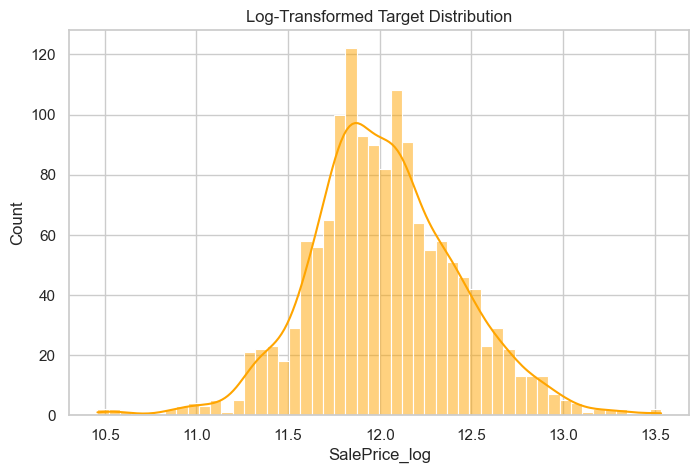

In [9]:
train_df[target+'_log'] = np.log1p(train_df[target])
plt.figure(figsize=(8,5))
sns.histplot(train_df[target+'_log'], kde=True, bins=50, color='orange')
plt.title('Log-Transformed Target Distribution')
plt.show()

## Missing Values Bar Plot
- Visualizes how many missing values each feature contains.
- Features like **PoolQC, MiscFeature, Alley, Fence** have extremely high missing counts.
- Helps identify:
  - Which features require imputation  
  - Which may be dropped  
  - Which indicate meaningful structural absence (e.g., no pool)

**Why it matters:**  
Missing values affect training quality. Understanding them ensures proper cleaning.


Columns with missing values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


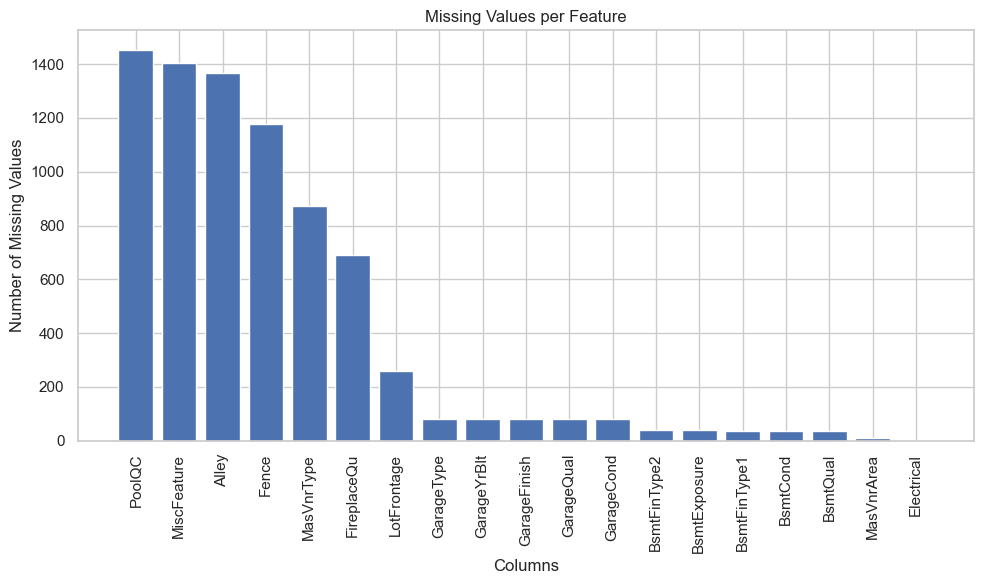

In [10]:
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:\n", missing)

plt.figure(figsize=(10, 6))
plt.bar(missing.index, missing.values)
plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.title("Missing Values per Feature")
plt.tight_layout()
plt.show()

## Feature Engineering Overview
No direct plot, but the engineered features impact the dataset:
- **TotalSF** combines multiple square-footage features.
- **HouseAge** captures how old the property is.
- **RemodAge** tracks renovation age.

**Why it matters:**  
These new features often show stronger correlation with SalePrice.

In [11]:
def feature_engineering(df):
   
    if 'TotalBsmtSF' in df.columns and '1stFlrSF' in df.columns and '2ndFlrSF' in df.columns:
        df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    if 'YearBuilt' in df.columns:
        df['HouseAge'] = 2024 - df['YearBuilt']

    if 'YearRemodAdd' in df.columns:
        df['RemodAge'] = 2024 - df['YearRemodAdd']
    
    if 'Id' in df.columns:
        df = df.drop(columns=['Id'])
    
    return df

train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log,TotalSF,HouseAge,RemodAge
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,2,2008,WD,Normal,208500,12.247699,2566,21,21
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,5,2007,WD,Normal,181500,12.109016,2524,48,48
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,9,2008,WD,Normal,223500,12.317171,2706,23,22
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,2,2006,WD,Abnorml,140000,11.849405,2473,109,54
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,12,2008,WD,Normal,250000,12.429220,3343,24,24


## Boxplot of SalePrice (Before Outlier Removal)
- Shows many **extreme outliers**, especially on the high-end.
- The long whisker and numerous points far above the box indicate anomalies.

**Why it matters:**  
Outliers distort model training and inflate error metrics.

## Histogram of SalePrice (Before Outlier Removal)
- Right-skewed distribution confirms outliers.
- Long tail on the right-hand side.

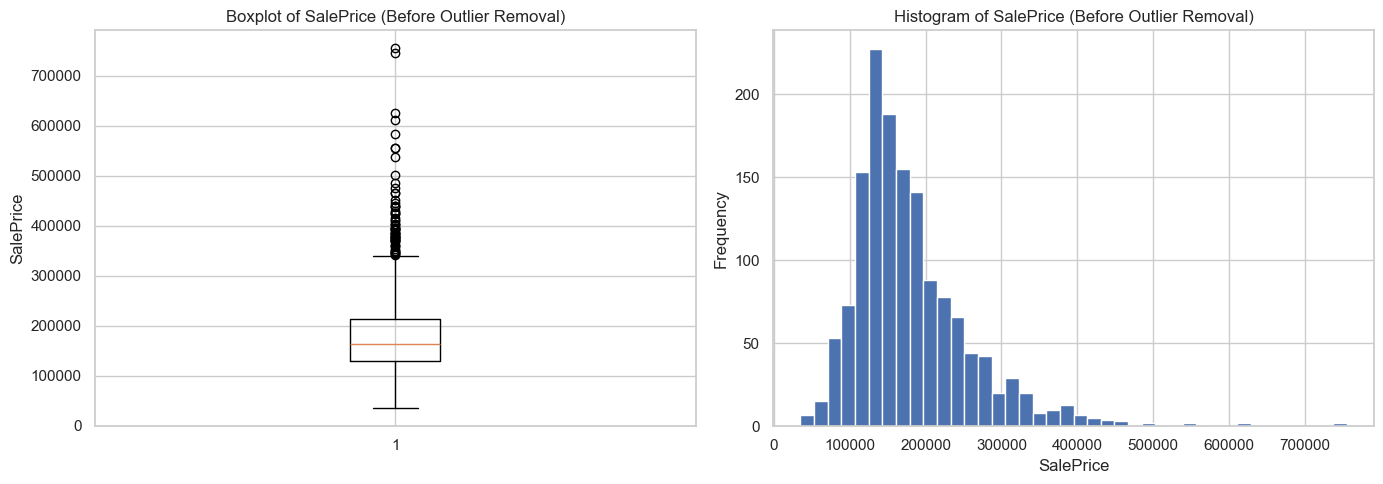

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(train_df[target])
axes[0].set_title(f"Boxplot of {target} (Before Outlier Removal)")
axes[0].set_ylabel(target)
axes[0].grid(True, axis='y')

axes[1].hist(train_df[target], bins=40)
axes[1].set_title(f"Histogram of {target} (Before Outlier Removal)")
axes[1].set_xlabel(target)
axes[1].set_ylabel("Frequency")
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

In [13]:
Q1 = train_df[target].quantile(0.25)
Q3 = train_df[target].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

initial_count = train_df.shape[0]
train_df = train_df[(train_df[target] >= lower) & (train_df[target] <= upper)]
removed_count = initial_count - train_df.shape[0]

print(f"Removed {removed_count} outliers from the target variable")

Removed 61 outliers from the target variable


## Boxplot of SalePrice (After Outlier Removal)
- Outlier range visibly shrinks.
- Distribution becomes tighter and more representative of the majority.

**Why it matters:**  
Models trained on cleaned targets are more stable and less biased.

## Histogram of SalePrice (After Outlier Removal)
- Much smoother and more symmetric distribution.
- Removes extreme values that could dominate training.

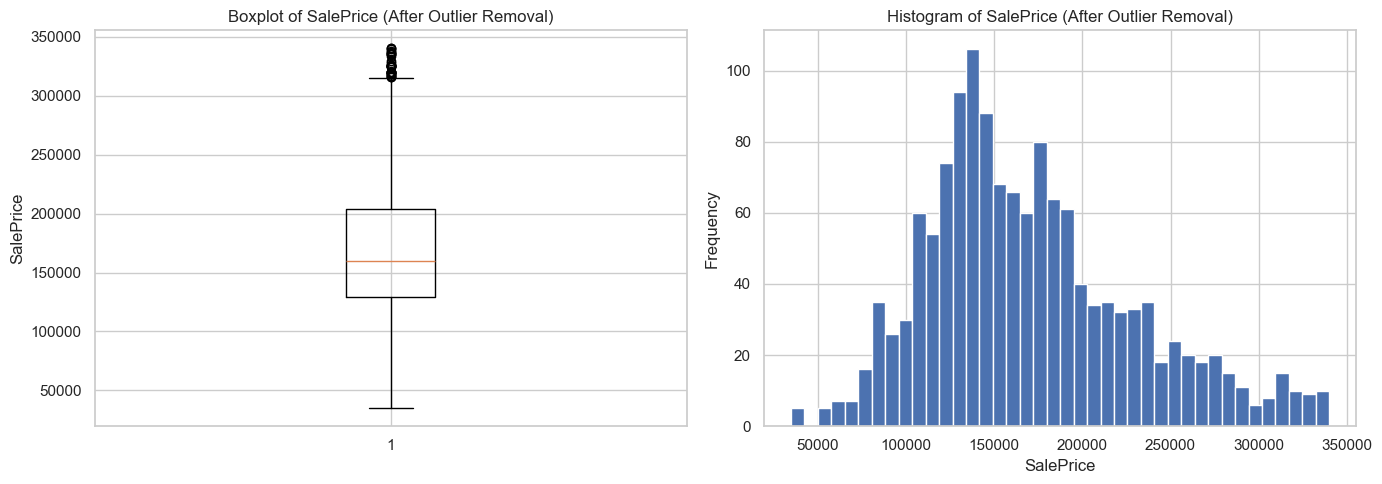

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(train_df[target])
axes[0].set_title(f"Boxplot of {target} (After Outlier Removal)")
axes[0].set_ylabel(target)
axes[0].grid(True, axis='y')

axes[1].hist(train_df[target], bins=40)
axes[1].set_title(f"Histogram of {target} (After Outlier Removal)")
axes[1].set_xlabel(target)
axes[1].set_ylabel("Frequency")
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

In [16]:
import warnings
warnings.filterwarnings('ignore')

### Top 20 Most Correlated Features with SalePrice

This bar chart highlights the **20 strongest predictors** of house prices based on Pearson correlation.

**Key Observations:**
- `OverallQual` (overall material & finish quality) is one of the strongest predictors of SalePrice.
- Size-related features (`TotalSF`, `GrLivArea`, `GarageCars`, `GarageArea`) show very high positive correlation.
- Temporal features like `YearBuilt`, `YearRemodAdd`, and `HouseAge` also contribute significantly.
- Basement and floor area features (`TotalBsmtSF`, `1stFlrSF`) demonstrate notable predictive power.

**Why this matters:**
- These features are prime candidates for model training.
- Understanding high-impact variables improves interpretability and model performance.
- Helps confirm real estate intuition: **bigger, newer, higher-quality homes sell for more**.

This visualization clearly identifies the most influential drivers of house prices, guiding model focus and feature importance interpretation.


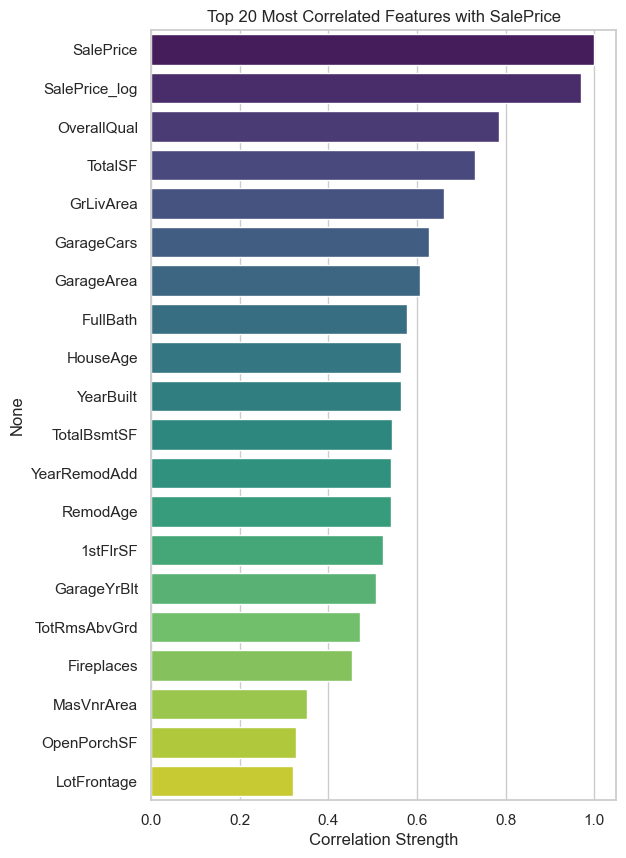

In [17]:
corr = train_df.corr(numeric_only=True)
top20 = corr['SalePrice'].abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(6,10))
sns.barplot(x=top20.values, y=top20.index, palette="viridis")
plt.title("Top 20 Most Correlated Features with SalePrice")
plt.xlabel("Correlation Strength")
plt.show()

### Correlation Heatmap of Numeric Features

The heatmap visualizes pairwise correlations across all numeric features in the dataset.

**What this plot shows:**
- **Red squares** → strong positive correlation  
- **Blue squares** → strong negative correlation  
- **White/light areas** → weak or no correlation  

**Insights:**
- Several features display strong correlation with **SalePrice**, including `OverallQual`, `GrLivArea`, `GarageCars`, and `TotalSF`.
- Correlations between related structural features (e.g., basement areas, garage variables, floor square footage) form visible clusters.
- The heatmap helps identify:
  - Redundant features  
  - Multicollinearity issues  
  - Potentially impactful predictors for modeling  

This heatmap provides a global view of how numerical variables relate to each other and guides feature selection and engineering.

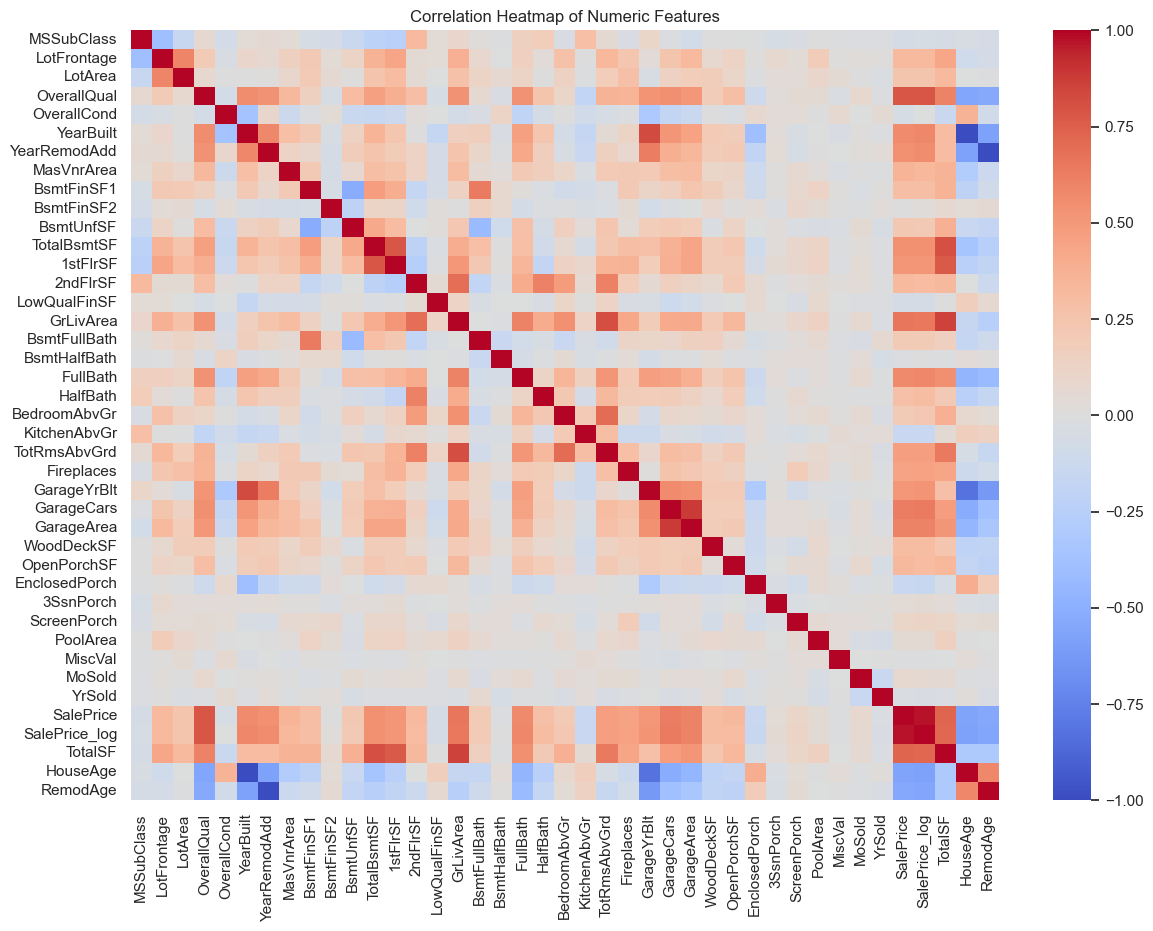

In [18]:
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()